# 네이버 영화평 감성분석

### 한글 폰트 사용

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
# 설치뒤 font-manager rebuild
import matplotlib.font_manager as fm
fm._rebuild()

### 설치 후 런타임에서 다시 시작해야 함

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumGothic')

### KoNLPy 설치

In [2]:
!pip install Konlpy

     |████████████████████████████████| 19.4MB 938kB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 450kB 39.7MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import konlpy
konlpy.__version__

'0.5.2'

### 파일 업로드

In [4]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving naver_movie_train.tsv to naver_movie_train.tsv


In [5]:
uploaded = files.upload()
filename1 = list(uploaded.keys())[0]

Saving naver_movie_test.tsv to naver_movie_test.tsv


In [6]:
import pandas as pd
train_df = pd.read_csv(filename, sep='\t')
test_df = pd.read_csv(filename1, sep='\t')
train_df.head(3)

,Unnamed: 0,id,document,label
0,0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0


### 한글 형태소 분석

In [7]:
from konlpy.tag import Okt
import tqdm.notebook as tn

In [8]:
# 토큰화와 불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','을','ㅋㅋ','ㅠㅠ','ㅎㅎ']
okt = Okt()

In [9]:
X_train = []
for sentence in tn.tqdm(train_df.document):
    morphs = okt.morphs(sentence, stem=True)
    temp_X = [word for word in morphs if not word in stopwords]
    X_train.append(temp_X)

In [10]:
X_test = []
for sentence in tn.tqdm(test_df.document):
    morphs = okt.morphs(sentence, stem=True)
    temp_X = [word for word in morphs if not word in stopwords]
    X_test.append(temp_X)

In [11]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

### 케라스로 인코딩

In [12]:
import numpy as np 
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
# 상위 30,000개의 단어로 인코딩
max_words = 30000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
X_train[:3]

[[48, 450, 15, 256, 655],
 [929, 453, 40, 598, 1, 210, 1445, 23, 957, 671, 18],
 [382, 2440, 25011, 2311, 5667, 2, 218, 8]]

In [16]:
# 전체 데이터의 길이 분포
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_train))/len(X_train))

리뷰 최대 길이: 69
리뷰 평균 길이: 10.660699220116468


In [17]:
# 샘플의 길이를 40으로 셋팅
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
y_train = train_df.label.values
y_test = test_df.label.values

### 1. LSTM 모델 정의/설정/학습/평가

In [19]:
model = Sequential([ 
    Embedding(max_words, 120),
    LSTM(128),
    Dense(1, activation='sigmoid')                    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         3600000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               127488    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,727,617
Trainable params: 3,727,617
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
import os
if not os.path.exists('model'):
    os.mkdir('model')
model_file = 'model/naver-lstm-best-model.h5'
mc = ModelCheckpoint(model_file, save_best_only=True, verbose=1)

In [22]:
history = model.fit(X_train, y_train, validation_split=0.2,
                    batch_size=60, epochs=4, callbacks=[mc])

Epoch 1/4
1944/1944 [==============================] - 93s 43ms/step - loss: 0.3868 - accuracy: 0.8238 - val_loss: 0.3509 - val_accuracy: 0.8472

Epoch 00001: val_loss improved from inf to 0.35088, saving model to model/naver-lstm-best-model.h5
Epoch 2/4
1944/1944 [==============================] - 82s 42ms/step - loss: 0.2890 - accuracy: 0.8769 - val_loss: 0.3414 - val_accuracy: 0.8521

Epoch 00002: val_loss improved from 0.35088 to 0.34139, saving model to model/naver-lstm-best-model.h5
Epoch 3/4
1944/1944 [==============================] - 81s 42ms/step - loss: 0.2326 - accuracy: 0.9047 - val_loss: 0.3768 - val_accuracy: 0.8506

Epoch 00003: val_loss did not improve from 0.34139
Epoch 4/4
1944/1944 [==============================] - 79s 41ms/step - loss: 0.1860 - accuracy: 0.9249 - val_loss: 0.4117 - val_accuracy: 0.8463

Epoch 00004: val_loss did not improve from 0.34139


In [24]:
best_model = load_model(model_file)

In [25]:
best_model.evaluate(X_test, y_test)

1532/1532 [==============================] - 6s 4ms/step - loss: 0.3481 - accuracy: 0.8483


[0.34806230664253235, 0.8483314514160156]

### 학습과정 시각화

In [26]:
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(1, len(y_acc)+1)

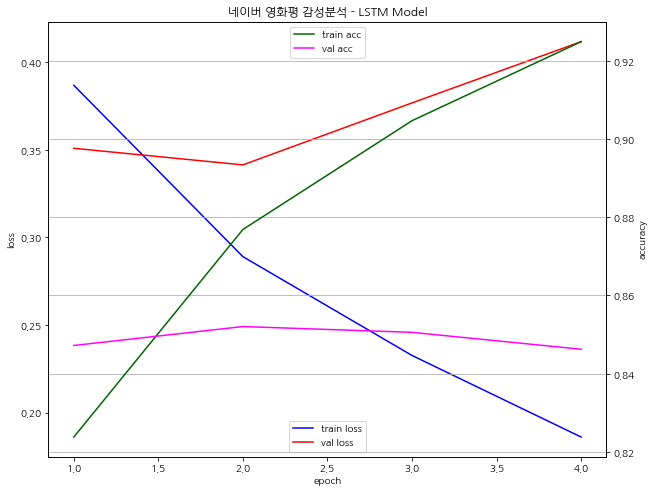

In [27]:
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c='blue', label='train loss')
ax0.plot(x_len, y_vloss, c='red', label='val loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c='darkgreen', label='train acc')
ax1.plot(x_len, y_vacc, c='magenta', label='val acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center'); ax1.legend(loc='upper center')
plt.title('네이버 영화평 감성분석 - LSTM Model')
plt.grid(); plt.show()

### 2. GRU Model

In [28]:
from tensorflow.keras.layers import GRU
model2 = Sequential([ 
    Embedding(max_words, 120),
    GRU(128),
    Dense(1, activation='sigmoid')                    
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 120)         3600000   
_________________________________________________________________
gru (GRU)                    (None, 128)               96000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,696,129
Trainable params: 3,696,129
Non-trainable params: 0
_________________________________________________________________


In [29]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model2_file = 'model/naver-gru-best-model.h5'
mc2 = ModelCheckpoint(model2_file, save_best_only=True, verbose=1)

In [31]:
history2 = model2.fit(X_train, y_train, validation_split=0.2,
                      batch_size=60, epochs=4, callbacks=[mc2])

Epoch 1/4
1944/1944 [==============================] - 79s 39ms/step - loss: 0.3801 - accuracy: 0.8259 - val_loss: 0.3421 - val_accuracy: 0.8519

Epoch 00001: val_loss improved from inf to 0.34206, saving model to model/naver-gru-best-model.h5
Epoch 2/4
1944/1944 [==============================] - 76s 39ms/step - loss: 0.2804 - accuracy: 0.8816 - val_loss: 0.3371 - val_accuracy: 0.8538

Epoch 00002: val_loss improved from 0.34206 to 0.33707, saving model to model/naver-gru-best-model.h5
Epoch 3/4
1944/1944 [==============================] - 76s 39ms/step - loss: 0.2220 - accuracy: 0.9094 - val_loss: 0.3770 - val_accuracy: 0.8488

Epoch 00003: val_loss did not improve from 0.33707
Epoch 4/4
1944/1944 [==============================] - 75s 39ms/step - loss: 0.1727 - accuracy: 0.9315 - val_loss: 0.4293 - val_accuracy: 0.8444

Epoch 00004: val_loss did not improve from 0.33707


In [32]:
best_model = load_model(model2_file)
best_model.evaluate(X_test, y_test)

1532/1532 [==============================] - 6s 4ms/step - loss: 0.3431 - accuracy: 0.8491


[0.3430898189544678, 0.8490866422653198]